In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=120, sci_mode=False)

In [3]:
n_clusters = 6
n_samples = 250

centroids = torch.rand(n_clusters, 2)*70-35

from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [4]:
def sample(m):
    return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [5]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [6]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _, ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color="k", mew=5)
        ax.plot(*centroid, markersize=5,  marker="x", color="m", mew=2)

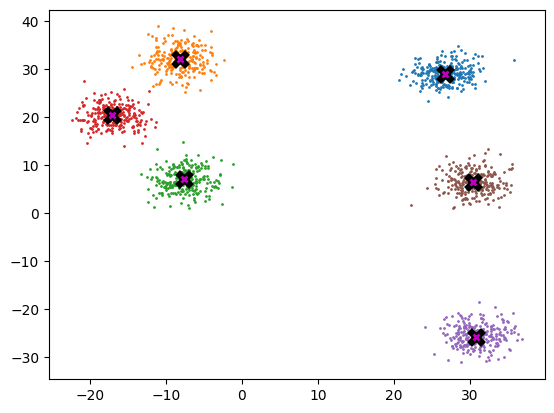

In [7]:
plot_data(centroids, data, n_samples)

## Mean shift

In [8]:
midp = data.mean(0)
midp

tensor([ 9.222, 11.604])

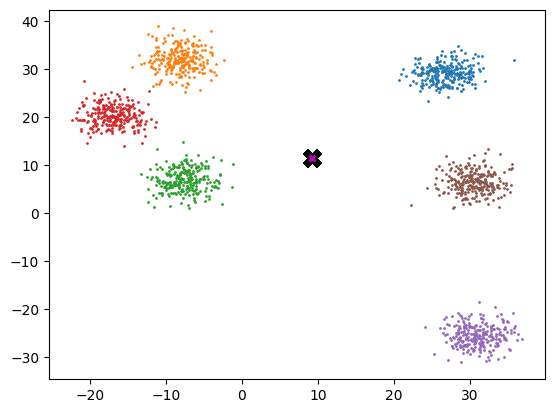

In [9]:
plot_data([midp]*6, data, n_samples)

In [10]:
def gaussian(d, bw):
    return torch.exp(-0.5*(d/bw)**2) / (bw*math.sqrt(2 * math.pi))

In [11]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

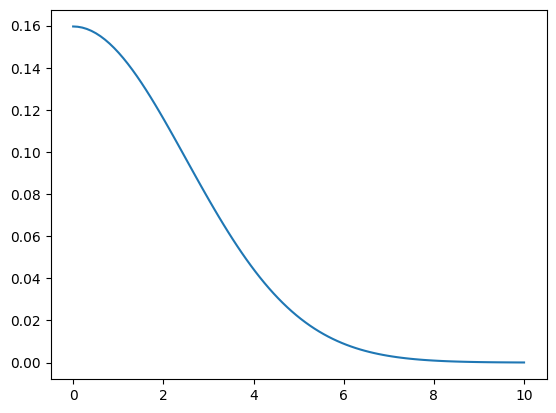

In [12]:
plot_func(partial(gaussian, bw=2.5))

In [13]:
def tri(d, i): return (-d+i).clamp_min(0)/i

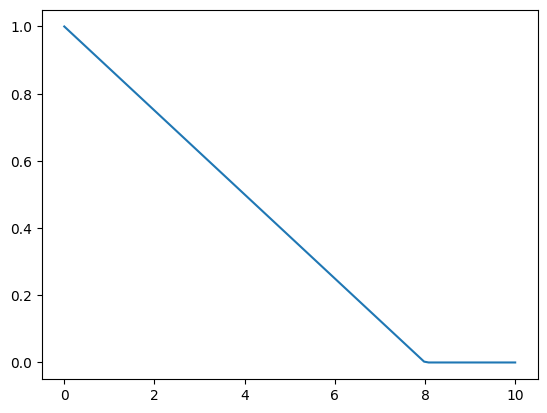

In [14]:
plot_func(partial(tri,i=8))

In [15]:
X = data.clone()
x = data[0]

In [16]:
x

tensor([26.204, 26.349])

In [17]:
x.shape,X.shape,x[None].shape,x[None]

(torch.Size([2]),
 torch.Size([1500, 2]),
 torch.Size([1, 2]),
 tensor([[26.204, 26.349]]))

In [18]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

Broadcast distance from x to all of X. x[None] expands x to a higher rank by enclosing it in an otherwise empty array. That gives a dimension of 1 (since there is one of x) which allows broadcasting along the 1500 members of X.

We will wind up doing this for each member of X. So we will need an additional dimension to give the space for the broadcast operation.

In [19]:
# alternate syntax. No need to do x[None] to do broadcasting
(x - X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [20]:
dist = ((x-X)**2).sum(1).sqrt()
dist

tensor([ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617])

## Homework 1 do it in einsum

can't exactly get rid of the `x-X`, or the `sqrt()`.

In [21]:
dists = x-X
(dists**2).sum(1)

tensor([  0.000,  15.199,  23.369,  ..., 310.729, 511.192, 467.316])

In [22]:
torch.einsum("ij,ij->i", dists, dists)
# Ok, so this works, but repeating dists
# to represent square is kind of dumb.

# But according to stack overflow, this is correct.

tensor([  0.000,  15.199,  23.369,  ..., 310.729, 511.192, 467.316])

In [23]:
_.sqrt()

tensor([ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617])

In [24]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [25]:
weight.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [26]:
weight[:,None].shape

torch.Size([1500, 1])

In [27]:
weight[:,None]*X

tensor([[    4.182,     4.205],
        [    1.215,     1.429],
        [    0.749,     0.706],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [28]:
torch.einsum("ij,ij->ij", weight[:,None], X)

tensor([[    4.182,     4.205],
        [    1.215,     1.429],
        [    0.749,     0.706],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [29]:
_.sum(1)

tensor([    8.386,     2.645,     1.455,  ...,     0.000,     0.000,     0.000])

In [30]:
torch.einsum("ij,ij->i", weight[:,None], X)

tensor([    8.386,     2.645,     1.455,  ...,     0.000,     0.000,     0.000])

In [31]:
def one_update(X):
    for i, x in enumerate(X):
        dist = ((x-X)**2).sum(1).sqrt()
        weight = gaussian(dist, 2.5)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [32]:
def one_update(X):
    for i, x in enumerate(X):
        dists = x - X
        dist = torch.einsum("ij,ij->i", dists, dists).sqrt()
        weight = gaussian(dist, 2.5)
        X[i] = torch.einsum("ij,ij->j", weight[:,None], X) / weight.sum()

In [33]:
def meanshift(data):
    X = data.clone()
    for _ in range(5): one_update(X)
    return X

In [34]:
%time X=meanshift(data)

CPU times: user 5.58 s, sys: 26.9 ms, total: 5.61 s
Wall time: 1.41 s


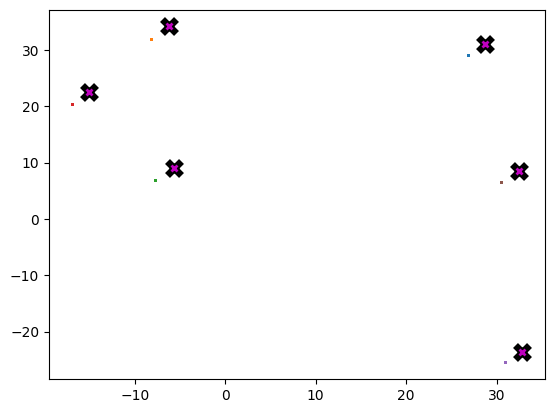

In [35]:
plot_data(centroids + 2, X, n_samples)

## Animation

In [36]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids + 5, X, n_samples, ax=ax)
    
# Create your own animation
X = data.clone()
fig, ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

In [37]:
bs = 5
X = data.clone()
x = X[:bs]
x.shape, X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [38]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2))

In [40]:
X[None].shape, x[:,None].shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]))

In [41]:
dist_b(X, x)

tensor([[    0.000,    15.199,    23.369,  ...,   310.729,   511.192,   467.316],
        [   15.199,     0.000,    24.782,  ...,   462.210,   702.676,   650.233],
        [   23.369,    24.782,     0.000,  ...,   375.315,   612.918,   547.383],
        [   13.887,     0.034,    24.687,  ...,   455.168,   693.578,   641.781],
        [   39.350,    30.768,     2.608,  ...,   431.604,   686.507,   614.274]])

In [42]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [45]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.000,     0.000,  ...,     0.000,     0.000,     0.000],
        [    0.000,     0.199,     0.000,  ...,     0.000,     0.000,     0.000],
        [    0.000,     0.000,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.000,     0.199,     0.000,  ...,     0.000,     0.000,     0.000],
        [    0.000,     0.000,     0.085,  ...,     0.000,     0.000,     0.000]])

In [46]:
weight.shape, X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [47]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [48]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [49]:
num

tensor([[154.171, 157.063],
        [249.625, 290.770],
        [135.529, 130.938],
        [254.853, 296.285],
        [ 72.145,  70.831]])

In [50]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[154.171, 157.063],
        [249.625, 290.770],
        [135.529, 130.938],
        [254.853, 296.285],
        [ 72.145,  70.831]])

In [52]:
weight@X

tensor([[154.171, 157.063],
        [249.625, 290.770],
        [135.529, 130.938],
        [254.853, 296.285],
        [ 72.145,  70.831]])

In [53]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [54]:
num/div

tensor([[26.232, 26.724],
        [25.787, 30.037],
        [29.831, 28.820],
        [25.750, 29.936],
        [30.485, 29.929]])

In [55]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for _ in range (5):
        for i in range(0, n, bs):
            s = slice(i, min(i + bs, n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@x/div
    return X

In [56]:
data = data.cuda()

In [59]:
X = meanshift(data).cpu()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)